In [150]:
import warnings; warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

In [160]:
df = pd.read_csv("./data/marketing_campaign.csv", sep = "\t")
df.head()

(2240, 29)

In [163]:
# Remove handful of entries with much larger incomes
df_income_reduced = df.query("Income < 100_000")
display([df.shape, "filtered to --> ", df_income_reduced.shape])

[(2240, 29), 'filtered to --> ', (2203, 29)]

In [266]:
cols_to_correlate = ["Income", "MntWines", "MntMeatProducts"]
corr_matrix = df_income_reduced[cols_to_correlate].corr(numeric_only=True)
display(corr_matrix)

,Income,MntWines,MntMeatProducts
Income,1.000000,0.733901,0.708879
MntWines,0.733901,1.000000,0.595692
MntMeatProducts,0.708879,0.595692,1.000000


### (1) Is income a good predictor of amount spent on wine?

In [187]:
plot_title = "Amount Spent on Wine vs. Income (Corr Coeff = "  + format(corr_matrix.MntWines.Income, ".2f") + ")"
fig = px.scatter(df_income_reduced, x="Income", y="MntWines", color="Education", title=plot_title)

fig.update_layout(
    xaxis_title="Yearly Income ($)",
    yaxis_title="Amount Spent on Wine ($)",
    title_x=0.5, title_font=dict(color="black"))

fig.add_annotation(
    dict(x=100_000, y=1000, ax=95_000, axref="x", ay=1500, ayref="y", 
         arrowcolor="black", arrowhead=1, arrowsize=3, showarrow=True,
         bgcolor="white", bordercolor="black",
         text="Income Above 100k Dropped", font=dict(color='red',size=10)))

fig.show()


#### Yes, it appears so. By filtering from the data set incomes above $100,000, the correlation (coefficient) between amount spent on wine and income is 0.73, indicating a strong correlation. A simple line fit mapping income to wine spending may produce reasonably accurate results.

#### But then again, maybe not! Notice how it fans out after about 40k.

In [264]:
income_caps = [10, 20, 30, 40, 50, 60, 70, 80]
income_capped_coeffs = []
for income in income_caps:
    query_str = "Income > " + format(income*1000, "d")
    df_income_capped = df_income_reduced.query(query_str)
    income_capped_corr_matrix = df_income_capped[cols_to_correlate].corr(numeric_only=True)
    income_capped_coeffs.append(income_capped_corr_matrix.MntWines.Income)


In [262]:
df_for_plotting = pd.DataFrame({"income caps":income_caps, "correlation coefficient":income_capped_coeffs})
fig = px.line(df_for_plotting, x="income caps", y="correlation coefficient", title="Correlation Coefficient vs. Income-Capped Data Set")

fig.update_layout(
    xaxis_title="Yearly Income Cap ($ x 1,000)",
    yaxis_title="Correlation Coefficient (unitless)",
    title_x=0.5, title_font=dict(color="black"))

fig.show()

### (2) Do "together" people purchase more wine?

In [294]:
# Recast married as "not single". Create a new categorical variable IsTogether = true when Together or Married. Calculate basic stats on partitioned data frames.
df["IsTogether"] = (df.Marital_Status == "Married") | (df.Marital_Status == "Together")
display(df.groupby("IsTogether")["MntWines"].agg(["mean", "median"]))

,mean,median
IsTogether,,
False,306.665829,172.0
True,302.430748,175.5


In [ ]:
sns.histplot(data=df, x="MntWines", hue="IsTogether", kde=True, bins=10, multiple="dodge", palette=sns.color_palette('bright')[:3])
plt.grid(True)
plt.xlabel("Amount Spent on Wine ($)")

Text(0.5, 9.444444444444438, 'Amount Spent on Wine ($)')

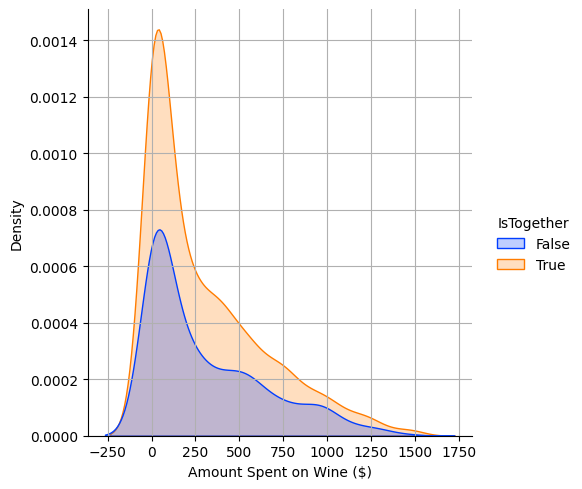

In [258]:
sns.displot(data=df, x="MntWines", kind="kde", hue="IsTogether", fill=True, palette=sns.color_palette('bright')[:3], multiple="layer")
plt.grid(True)
plt.xlabel("Amount Spent on Wine ($)")

#### On average, no - compare the average of $302 for together people, and $306 for not toegether. However, these differences are small enough as to be irrelevant. The median purchase amounts are also within a few dollars of each other.

### (3) Do people who buy more wine also buy more meat?

In [269]:
plot_title = "Amount Spent on Meant Products vs. Amount Spent on Wine (Corr Coeff = "  + format(corr_matrix.MntWines.MntMeatProducts, ".2f") + ")"
fig = px.scatter(df.query("MntMeatProducts < 1000"), x="MntWines", y="MntMeatProducts", title=plot_title)

fig.update_layout(
    xaxis_title="Amount Spent on Wine ($)",
    yaxis_title="Amount Spent on Meat Products ($)",
    title_x=0.5, title_font=dict(color="black"))

fig.show()

In [296]:
bin_edges = np.arange(0, 1600, 50)
bin_centers = [0.5*(bin_edges[k] + bin_edges[k + 1]) for k in range(len(bin_edges) - 1)]
dd = df[cols_to_correlate].groupby(pd.cut(df["MntWines"], bin_edges)).mean()
dd["MntWinesAvg"] = bin_centers
#display(dd)
fig = px.bar(dd, x="MntWinesAvg", y="MntMeatProducts", title="Average Amount Spent on Meat Products vs. Amount Spent on Wine")
fig.add_hline(y=dd.MntMeatProducts.mean(), line_width=3, line_dash="dash", line_color="black")

fig.update_layout(
    xaxis_title="Amount Spent on Wine ($)",
    yaxis_title="Average Amount Spent on Meat Products ($)",
    title_x=0.5, title_font=dict(color="black"))

fig.show()

#### Answer - not really, surprisingly to me. The amount spent on meat is pretty flat at about $300 across after wine spends exceed about $200